<a href="https://colab.research.google.com/github/sravyagadam/ML_Classification/blob/main/AlmaBetter_ML_Classification_CardioVascularRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting all dependencies

In [1]:
!pip install imbalanced-learn >> /dev/null
!pip install smote-variants >> /dev/null
!pip install CatBoost>> /dev/null
!pip install mglearn>>/dev/null


In [91]:
import pandas as pd
#creating deepcopy of model instances
from copy import deepcopy
import time
import numpy as np
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as s
from sklearn.impute import KNNImputer

from numpy import math

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import train_test_split,GridSearchCV, KFold

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,recall_score,precision_score
import smote_variants as sv
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import cohen_kappa_score
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier



In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# mount drive and give path of dataset
data = pd.read_csv("/content/drive/MyDrive/cardiovascular_Classification_sravya/data_cardiovascular_risk.csv")

In [6]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1072,1072,55,NaN,F,NO,0.0,0.0,0,0,0,240.0,145.0,96.0,26.27,72.0,NaN,0
3019,3019,45,1.0,M,YES,3.0,0.0,0,0,0,280.0,128.0,82.0,29.17,60.0,62.0,0
1015,1015,36,2.0,M,NO,0.0,0.0,0,1,0,183.0,140.0,85.0,24.39,67.0,84.0,0
1394,1394,44,1.0,F,NO,0.0,0.0,0,0,0,202.0,155.0,85.0,24.04,83.0,68.0,0
2984,2984,49,1.0,M,YES,20.0,0.0,0,0,0,222.0,124.0,86.0,27.25,80.0,NaN,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [8]:
data[["diabetes","glucose"]]

,diabetes,glucose
0,0,80.0
1,0,75.0
2,0,94.0
3,0,94.0
4,0,77.0
...,...,...
3385,0,103.0
3386,0,84.0
3387,0,72.0
3388,0,85.0


Checking for any duplicates and null values

In [9]:
# duplicate
len(data[data.duplicated()])

0

In [10]:
data.isna().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

##Handling null values

In [11]:
#Check values of diabetes where glucose is null
data[data['glucose'].isna()]['diabetes'].value_counts()

0    301
1      3
Name: diabetes, dtype: int64

In [12]:
## Null handling for column glucose
data.loc[(data['glucose'].isna()) & (data['diabetes']==0) ,['glucose'] ]=data[data['diabetes']==0]['glucose'].median()
data.loc[(data['glucose'].isna()) & (data['diabetes']==1) ,['glucose'] ]=data[data['diabetes']==1]['glucose'].median()

In [13]:
# Imputed null values with mode
data['BPMeds']=data['BPMeds'].fillna(s.mode(data['BPMeds']))

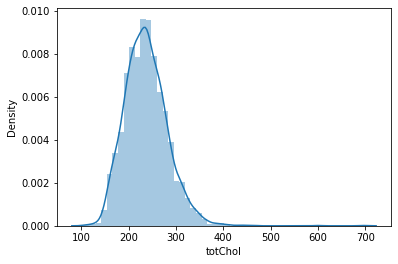

In [14]:
sns.distplot(data['totChol']);

In [15]:
# Ipute with median
data['totChol']=data['totChol'].fillna(data['totChol'].median())
# Impute with median
data['BMI']=data['BMI'].fillna(data['BMI'].median())

In [16]:
# Impute with random number between 5 and 30
data['cigsPerDay']=data['cigsPerDay'].fillna(np.random.randint(5,30))
# Impute with mean, only one null value
data['heartRate']=data['heartRate'].fillna(np.mean(data['heartRate']))
# Encoding the categorical columns
data['is_smoking']=data['is_smoking'].apply(lambda x:1 if x=='YES' else 0)
data['sex']=data['sex'].apply(lambda x:1 if x=='M' else 0)

In [17]:
data.isna().sum()

id                  0
age                 0
education          87
sex                 0
is_smoking          0
cigsPerDay          0
BPMeds              0
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                 0
heartRate           0
glucose             0
TenYearCHD          0
dtype: int64

In [18]:
#data[data['glucose'].isna()]
# define imputer
imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

In [19]:
# fit on the dataset
imputer.fit(data)

KNNImputer(n_neighbors=10)

In [20]:
# transform the dataset
data_trans = pd.DataFrame(imputer.transform(data),columns=data.columns)

## All the null values are handled

In [21]:
data_trans.isna().sum().sum()

0

In [22]:
data=data_trans.copy()

EDA Part 

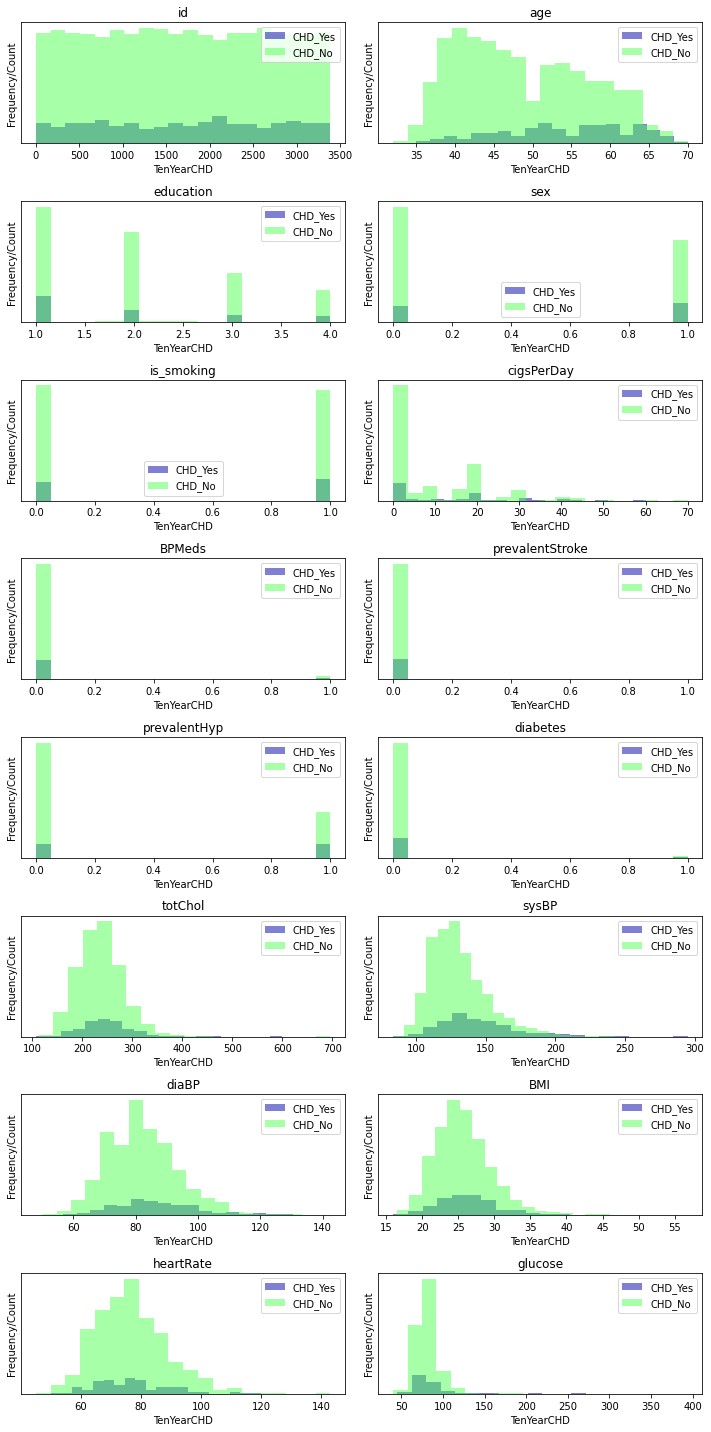

In [23]:
Risk_Yes =data.loc[data['TenYearCHD']==1]
Risk_No =data.loc[data['TenYearCHD']==0]
fig, axes = plt.subplots(8,2, figsize=(10,20))
ax = axes.ravel()
for i in range(16):
  ax[i].hist(Risk_Yes.iloc[:,i], bins=20, color=mglearn.cm3(0), alpha=.5)
  ax[i].hist(Risk_No.iloc[:,i], bins=20, color=mglearn.cm3(2), alpha=.5)
  ax[i].set_title(list(Risk_Yes)[i])
  ax[i].set_yticks(())
  ax[i].set_xlabel("TenYearCHD")
  ax[i].set_ylabel("Frequency/Count")
  ax[i].legend(["CHD_Yes", "CHD_No"], loc="best")
fig.tight_layout()

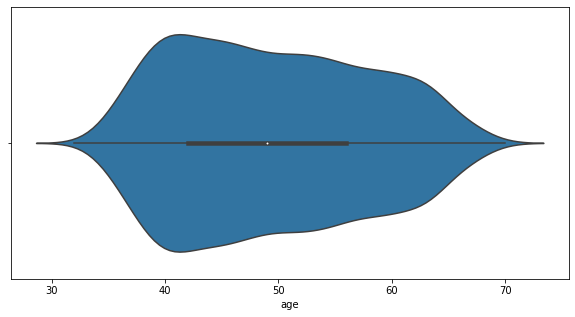

In [24]:
plt.figure(figsize = (10,5))
ax= sns.violinplot(data['age'])
plt.show()

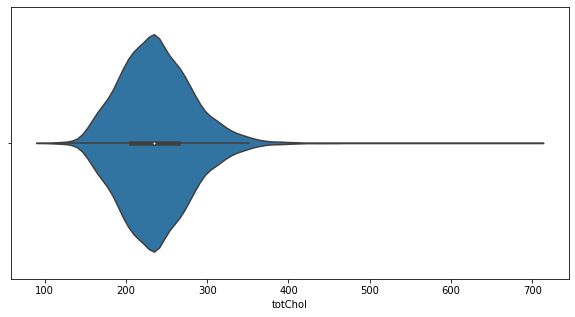

In [25]:
plt.figure(figsize = (10,5))
ax= sns.violinplot(data['totChol'])
plt.show()

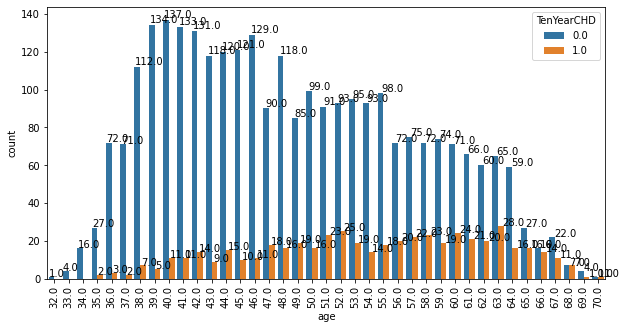

In [26]:
plt.figure(figsize = (10,5))
ax= sns.countplot(x = "age", hue = "TenYearCHD", data = data)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.xticks(rotation = 90)
plt.show()

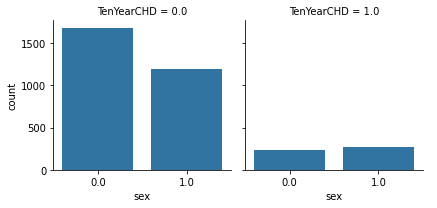

In [27]:


fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

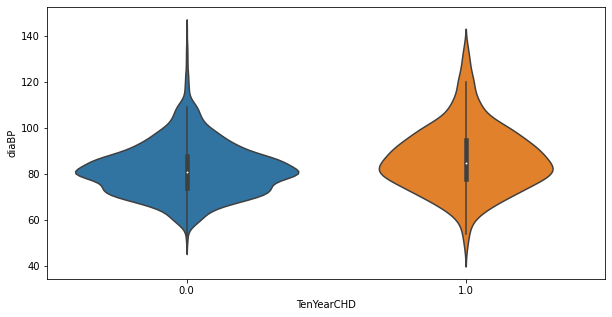

In [28]:
plt.figure(figsize = (10,5))
sns.violinplot(y = 'diaBP', x = 'TenYearCHD', data = data)
plt.show()

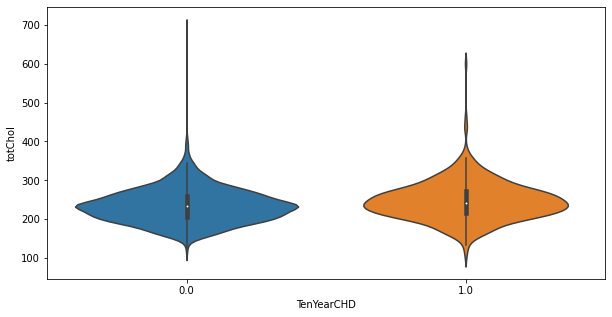

In [29]:
plt.figure(figsize = (10,5))
sns.violinplot(y = 'totChol', x = 'TenYearCHD', data = data)
plt.show()


##Dropping irrelavant variables and duplicates if any.

In [30]:
data.columns

Index(['id', 'age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [31]:
data.drop("id", axis=1, inplace=True)
data.drop_duplicates(inplace=True)

In [32]:
data.shape

(3390, 16)

here shape confirms that there are no duplicates and total columns reduced to 16

In [33]:
data.describe()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.00000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000
mean,49.542183,1.971357,0.432743,0.497640,9.179351,0.029499,0.006490,0.315339,0.025664,237.039823,132.60118,82.883038,25.793251,75.977279,81.783776,0.150737
std,8.592878,1.007577,0.495529,0.500068,11.918269,0.169224,0.080309,0.464719,0.158153,44.994205,22.29203,12.023581,4.107026,11.970102,23.249836,0.357846
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.030000,68.000000,72.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,1.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,27.997500,83.000000,85.000000,0.000000
max,70.000000,4.000000,1.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [34]:
unique, counts = np.unique(data['TenYearCHD'], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 2.879e+03]
 [1.000e+00 5.110e+02]]


It is evident that the dataset is imbalanced as it comprises of very few CHD-Yes(444) cases in comparision to CHD-No(2483) cases. Therfore, we need to balance them before we provide it to our model training.

In [35]:

X=data.drop(['TenYearCHD'],axis=1).values
y=data['TenYearCHD'].values

In [36]:
# handling data imbalance
oversampler= sv.distance_SMOTE()
X_msmote, y_msmote= oversampler.sample(X, y)

2021-12-29 17:32:00,901:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [37]:
#Create new Dataframe with balanced data
data_new=pd.DataFrame(X_msmote,columns=data.columns[:-1])
data_new['TenYearCHD']=pd.DataFrame(y_msmote)
data_new['TenYearCHD'].value_counts()

0.0    2879
1.0    2879
Name: TenYearCHD, dtype: int64

In [38]:
# Split traget and independent features
X=data_new.drop(['TenYearCHD'],axis=1)
y=data_new['TenYearCHD']

In [39]:
#Difference of BP to create a new feature
X['pulse']=X['sysBP']-X['diaBP']
X.drop(['sysBP','diaBP'],axis=1,inplace=True)

In [40]:
# Split data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=10)

In [41]:
# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [42]:
corr = data.corr()
corr[-3:]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
heartRate,-0.002595,-0.046085,-0.118680,0.062176,0.066343,0.018103,-0.019184,0.150766,0.039742,0.086945,0.178178,0.174893,0.069511,1.000000,0.079693,0.020224
glucose,0.111474,-0.036060,-0.003555,-0.058201,-0.062795,0.060645,0.023350,0.082752,0.624309,0.059785,0.141086,0.070609,0.087148,0.079693,1.000000,0.134363
TenYearCHD,0.224927,-0.053819,0.084647,0.034143,0.063537,0.087349,0.068627,0.166544,0.103681,0.093605,0.212703,0.135979,0.066134,0.020224,0.134363,1.000000


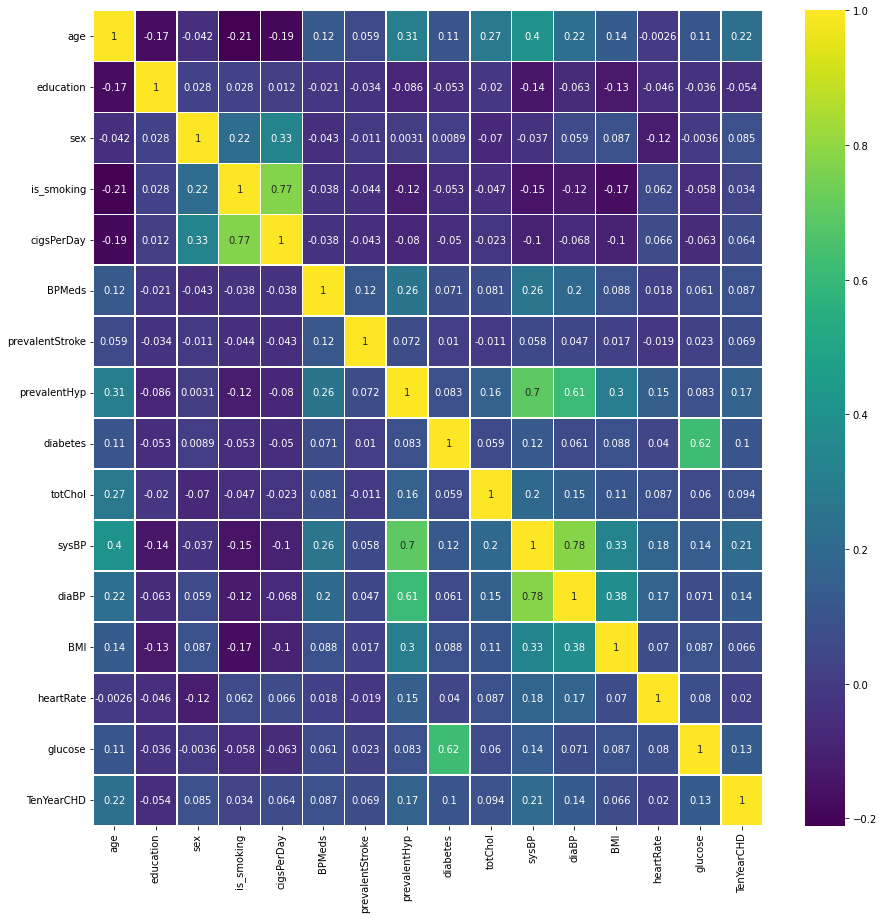

In [43]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, cmap='viridis', linewidths=.5)

In [44]:
unique, counts = np.unique(data['TenYearCHD'], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 2.879e+03]
 [1.000e+00 5.110e+02]]


Here is a data ready to be trained and tested, using any machine learning classification algorithm. 

## Decision Tree Classification

Training the Decision Tree Classification model on the Training set

In [46]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Making the Confusion matrix

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(601, 628, 109, 102)

Calculating accuracy score

In [49]:
accuracy_score_DecisionTree = accuracy_score(y_test, y_pred)
print(accuracy_score_DecisionTree)

0.8534722222222222


In [50]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.54340278 0.63888889 0.93402778 0.92708333 0.921875   0.89930556
 0.92881944 0.92013889 0.91304348 0.90608696]
The Cross Validation accuracy is: 85.33%


Classification report

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86       737
         1.0       0.85      0.85      0.85       703

    accuracy                           0.85      1440
   macro avg       0.85      0.85      0.85      1440
weighted avg       0.85      0.85      0.85      1440



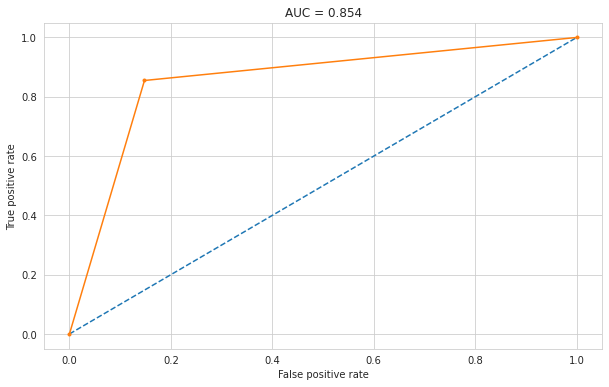

In [53]:
# ROC curve and AUC 
probs = classifier.predict(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

Hyper parameter tuning

In [54]:
dt = DecisionTreeClassifier(random_state=42)

In [55]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [56]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [57]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: user 509 ms, sys: 67.1 ms, total: 576 ms
Wall time: 3.81 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [58]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016680,0.006005,0.003296,0.003002,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.864815,0.855556,0.883225,0.850788,0.863596,0.012405,37
1,0.012441,0.002545,0.001523,0.000331,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.864815,0.855556,0.883225,0.850788,0.863596,0.012405,37
2,0.013061,0.002717,0.001324,0.000099,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.864815,0.855556,0.883225,0.850788,0.863596,0.012405,37
3,0.014190,0.003744,0.002121,0.001462,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.864815,0.855556,0.883225,0.850788,0.863596,0.012405,37
4,0.011865,0.002378,0.001489,0.000427,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.864815,0.855556,0.883225,0.850788,0.863596,0.012405,37


In [59]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
10,0.019419,0.006005,0.001370,0.000073,gini,5,5,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.887963,0.889815,0.901761,0.879518,0.889764,0.007940,1
11,0.016133,0.002609,0.001322,0.000046,gini,5,10,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.882407,0.888889,0.904541,0.881372,0.889302,0.009258,2
17,0.016922,0.000120,0.001341,0.000058,gini,10,20,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.877778,0.880556,0.912882,0.878591,0.887452,0.014717,3
22,0.019606,0.003968,0.001438,0.000149,gini,20,20,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.877778,0.880556,0.912882,0.878591,0.887452,0.014717,3
12,0.014888,0.000995,0.001782,0.000698,gini,5,20,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.881481,0.882407,0.905468,0.880445,0.887450,0.010426,5


In [60]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

In [61]:
dt_best = grid_search.best_estimator_

In [62]:
classifier_tuning = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)
classifier_tuning.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)

In [64]:
y_pred = classifier_tuning.predict(X_test)
tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, y_pred).ravel()
tp_t,fp_t, fn_t, tp_t

(568, 32, 135, 568)

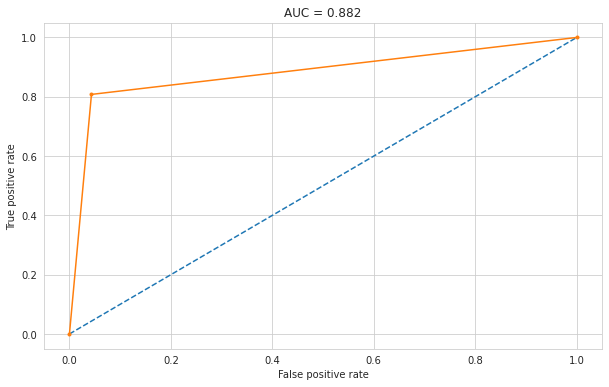

In [66]:
# ROC curve and AUC 
probs = classifier_tuning.predict(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##XGB Classifier

Training XGBClassifier model on the Training set

In [68]:
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state=0)
classifier.fit(X_train, y_train)

XGBClassifier()

Making the Confusion Matrix

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(579, 730, 7, 124)

Calculating accuracy score

In [71]:
accuracy_score_XGBClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_XGBClassifier)

0.9090277777777778


In [72]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.51388889 0.62326389 0.99131944 0.984375   0.99131944 0.98958333
 0.99131944 0.98958333 0.99478261 0.98956522]
The Cross Validation accuracy is: 90.59%


Classification report

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92       737
         1.0       0.99      0.82      0.90       703

    accuracy                           0.91      1440
   macro avg       0.92      0.91      0.91      1440
weighted avg       0.92      0.91      0.91      1440



##Hypertuning XGBoost 

In [ ]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}
gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)